## Did Azithromycin prevent death by coronary heart disease?

Within the past decade, serious attention has been given to the possibility of bacterial vectors as causal factors of atherosclerosis. To date, the greatest amount of information has related to the intracellular organism Chlamydia pneumoniae. This interest has been stimulated by the frequent finding of bacterial antigens and, occasionally, recoverable organisms, within human atherosclerotic plaque. Indirect evidence for and against the benefit of anti-Chlamydia antibiotic agents comes from epidemiologic studies.

Anderson JL, Muhlestein JB. Antibiotic trials for coronary heart disease. Tex Heart Inst J. 2004;31(1):33-8. PMID: 15061624

<u>Causal element description</u>

Population: patients with coronary syndrome

Outcome: death (`dod` == T|F)

Exposure: Azithromycin analog

Confounder: Age, Gender

In [1]:
%%script bash

-- work-in-progress pseudo-code below --

Given three datasets: df_diag, df_pat, df_pharm

Population definition:
1. search for "coronary" from df_diag (A)
2. INNER join A with df_pat by subject_id (B)

Outcome definition:
3. conditional B (dod = 0 | dod = 1) (outcome[0,1])

Exposure definition:
4. search for "thromycin" from df_pharm (C)
5. conditional C >= 0 to find exposure == 1 (D)
6. INNER join outcome [0,1] with D by subject_id (treated_outcome)
7. FULL OUTER join outcome [0,1] with D by subject_id (not_treated_outcome)

Micro data generation:
8. FULL join treated_outcome and not_treated_outcome (micro_data)

Data finalization:
9. Impute missing values
10. Remove irrelevant columns

Couldn't find program: 'bash'


## Data Preparation Stage

### Import dependencies

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 0
import matplotlib.pyplot as plt
import seaborn as sns

import time
import zipfile
import gzip
import io
import warnings
warnings.simplefilter('ignore')

from src import RWE

TRUNCATED_DATASETS = False #uses truncated dataset if true
EXPORT_NEW_TRUNCATED_DATEASETS = False

### Define filepath

In [3]:
# patient dataset contains dod information
FILEPATH_patients = 'C:/Users/t-jongshin/Desktop/workstation/2021_rwe/api/asset/mimic-iv-1.0/core/patients.csv.gz'

# patient visit dataset contains icd information (requires deidentification)
FILEPATH_d_diagno = 'C:/Users/t-jongshin/Desktop/workstation/2021_rwe/api/asset/mimic-iv-1.0/hosp/d_icd_diagnoses.csv.gz'
FILEPATH_diagnose = 'C:/Users/t-jongshin/Desktop/workstation/2021_rwe/api/asset/mimic-iv-1.0/hosp/diagnoses_icd.csv.gz'

# patient pharmacy dataset contains drug information
FILEPATH_pharmacy = 'C:/Users/t-jongshin/Desktop/workstation/2021_rwe/api/asset/mimic-iv-1.0/hosp/pharmacy.csv.gz'

### Read from gunzip 

In [4]:
s = time.time()

if TRUNCATED_DATASETS:
    dat_patients = pd.read_csv('asset/patients.csv')
    dat_diagnose = pd.read_csv('asset/diagnoses_icd.csv')
    dat_pharmacy = pd.read_csv('asset/pharmacy.csv')
    dic_diagnose = pd.read_csv('asset/d_icd_diagnoses.csv')

else:
    with gzip.open(FILEPATH_patients, 'rb') as f:    
        dat_patients = pd.read_csv(f)

    with gzip.open(FILEPATH_diagnose, 'rb') as f:    
        dat_diagnose = pd.read_csv(f)

    with gzip.open(FILEPATH_pharmacy, 'rb') as f:    
        dat_pharmacy = pd.read_csv(f)

    with gzip.open(FILEPATH_d_diagno, 'rb') as f:    
        dic_diagnose = pd.read_csv(f)

print(f'execution took {round(time.time() - s, 2)} seconds')

execution took 167.48 seconds


In [5]:
# for exporting trimmed datasets
if EXPORT_NEW_TRUNCATED_DATEASETS:
    dat_pharmacy[:100000].to_csv('asset/pharmacy.csv', index=False)
    dat_patients[:100000].to_csv('asset/patients.csv', index=False)
    dat_diagnose[:100000].to_csv('asset/diagnoses_icd.csv', index=False)
    dic_diagnose.to_csv('asset/d_icd_diagnoses.csv', index=False)

In [6]:
display(dat_patients.iloc[0:1,:])
display(dat_diagnose.iloc[0:1,:])
display(dat_pharmacy.iloc[0:1,:])

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9


,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,verifiedtime,route,frequency,disp_sched,infusion_type,sliding_scale,lockout_interval,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,17868682,22726960,2697460,17868682-19,2160-01-07 14:00:00,2160-01-07 14:00:00,NaN,IV Large Volume,Discontinued,2160-01-07 13:06:18,2160-01-07 13:06:18,IV,ASDIR,NaN,C,N,NaN,NaN,NaN,NaN,NaN,Ongoing,NaN,Enter on Label,NaN,Distribution-Floor Stock,NaN


## 1. Define population
Filter patients by all conditions associated with coronary syndromes

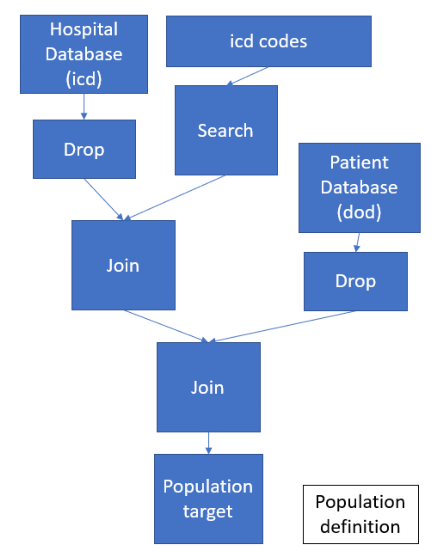

In [35]:
plt.imshow(plt.imread('https://i.ibb.co/LzmP3Hm/populations.png'));
plt.axis('off');
plt.rcParams['figure.figsize'] = (30,30)

### {Search} `long_title` column from dic_diagnose by the keyword `coronary`

In [7]:
lst_icd = RWE.rwe_dataprep.df_search(dic_diagnose, 'long_title', 'coronary')
lst_icd

,icd_code,icd_version,long_title
4712,4111,9,intermediate coronary syndrome
4713,41181,9,acute coronary occlusion without myocardial in...
4719,41400,9,coronary atherosclerosis of unspecified type o...
4720,41401,9,coronary atherosclerosis of native coronary ar...
4721,41402,9,coronary atherosclerosis of autologous vein by...
...,...,...,...
99666,V4581,9,aortocoronary bypass status
99667,V4582,9,percutaneous transluminal coronary angioplasty...
109648,Z951,10,presence of aortocoronary bypass graft
109652,Z955,10,presence of coronary angioplasty implant and g...


### {Drop} columns of `hospital dataset` that will not be used

In [8]:
temp = RWE.rwe_dataprep.drop_df(dat_diagnose, choose_columns=['subject_id', 'icd_code'])

### {Merge} search result (by `icd_code`) with the hospital dataset

In [9]:
temp = RWE.rwe_dataprep.join_df(temp, lst_icd, how='inner', on='icd_code', trim='subject_id')

### {Drop} columns from patient dataset that will not be used

In [10]:
temp2 = RWE.rwe_dataprep.drop_df(dat_patients, choose_columns=['subject_id', 'gender', 'anchor_age', 'dod'])

### {Merge} search result (by `subject_id`) with the patient dataset

In [11]:
population = RWE.rwe_dataprep.join_df(temp, temp2, on='subject_id')
population

,subject_id,gender,anchor_age,dod
0,17872922,M,88,2141-03-27
2,12201410,M,75,NaN
6,12849817,M,65,NaN
11,12292383,M,75,NaN
17,18739672,M,71,NaN
...,...,...,...,...
73693,15335760,M,33,2144-08-05
73694,17176505,M,79,NaN
73695,18353395,M,73,NaN
73696,17177034,M,75,NaN


## 2. Define Outcome
The outcome is defined based on the column `dod` information. The end result is the list of all-cause death with the coronary syndrome associated conditions. 

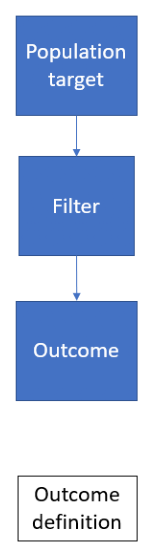

In [39]:
plt.imshow(plt.imread('https://i.ibb.co/T2gt6KK/outcome.png'));
plt.axis('off');
plt.rcParams['figure.figsize'] = (5,5)

### {Filter} `dod` column for non-missing values (binary output)

In [12]:
# list of all-cause death with the coronary syndrome associated conditions
outcome = RWE.rwe_dataprep.filter_df(population, 'dod', method='0')
outcome

,subject_id,gender,anchor_age,dod,dod_bin
0,17872922,M,88,2141-03-27,True
2,12201410,M,75,NaN,False
6,12849817,M,65,NaN,False
11,12292383,M,75,NaN,False
17,18739672,M,71,NaN,False
...,...,...,...,...,...
73693,15335760,M,33,2144-08-05,True
73694,17176505,M,79,NaN,False
73695,18353395,M,73,NaN,False
73696,17177034,M,75,NaN,False


## 3. Define exposure
The exposure is defined based on the `medication` column

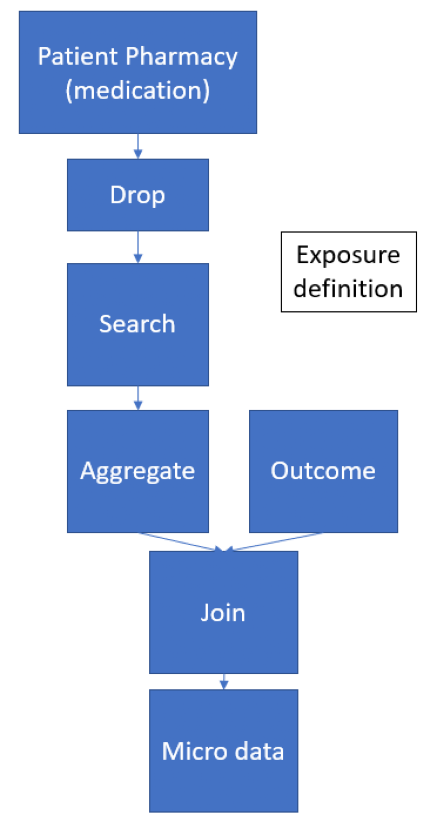

In [42]:
plt.imshow(plt.imread('https://i.ibb.co/7SZ5Y53/exposure.png'));
plt.axis('off');
plt.rcParams['figure.figsize'] = (25,25)

### Filter pharmacy list by any drug analog of Azithromycin

### {Drop} columns from `pharmacy dataset` that will not be used

In [13]:
temp = RWE.rwe_dataprep.drop_df(dat_pharmacy, choose_columns=['subject_id', 'medication'])

### {Search} `medication` column from dat_pharmacy by the keyword `thromycin`

In [14]:
# list of drug names containing thromycin
temp = RWE.rwe_dataprep.df_search(temp, 'medication', 'thromycin', return_both=True)
temp.head()

,subject_id,medication,medication_bin
0,17868682,NaN,False
1,17868682,pneumococcal vac polyvalent,False
2,17868682,sodium chloride 0.9% flush,False
3,17868682,ondansetron,False
4,17868682,morphine sulfate,False


### {Aggregate} searched dat_pharmacy by `subject_id` column based on the passed dictionary relation

In [15]:
temp = RWE.rwe_dataprep.agg_df(temp, 'subject_id', {'medication_bin':'choose'})
temp

,medication_bin
subject_id,
10000019,True
10000032,False
10000044,True
10000074,True
10000084,False
...,...
19999768,True
19999784,False
19999828,False


### Create microdata

In [16]:
microdata = RWE.rwe_dataprep.join_df(temp, outcome, on='subject_id')
microdata

,subject_id,medication_bin,gender,anchor_age,dod,dod_bin
0,10000764,False,M,86,NaN,False
1,10000980,False,F,73,NaN,False
2,10001176,False,F,64,NaN,False
3,10001884,True,F,68,2131-01-20,True
4,10002013,False,F,53,NaN,False
...,...,...,...,...,...,...
34035,19997473,False,F,82,NaN,False
34036,19997911,False,F,79,NaN,False
34037,19998497,False,F,82,NaN,False
34038,19999379,False,F,91,NaN,False


### Quality check for potential overlap

In [17]:
overlap = RWE.rwe_dataprep.join_df(microdata[microdata['medication_bin'] == True][['subject_id']].drop_duplicates(), microdata[microdata['medication_bin'] == False][['subject_id']].drop_duplicates(), on='subject_id')
overlap

,subject_id


In [18]:
print(f'There are {overlap.size} individuals who has history taking the analogs but also has taken other drugs')

There are 0 individuals who has history taking the analogs but also has taken other drugs


### Conduct general {QA} on `microdata`

In [19]:
microdata = RWE.rwe_dataprep.qa_df(microdata, exposure='medication_bin', outcome='dod_bin')

### Column Stats

In [20]:
microdata.groupby('gender').count()

,subject_id,medication_bin,anchor_age,dod,dod_bin
gender,,,,,
F,12142,12142,12142,1224,12142
M,21898,21898,21898,1873,21898


In [21]:
microdata.groupby('dod_bin').count()

,subject_id,medication_bin,gender,anchor_age,dod
dod_bin,,,,,
0,30943,30943,30943,30943,0
1,3097,3097,3097,3097,3097


In [22]:
microdata.groupby('medication_bin').count()

,subject_id,gender,anchor_age,dod,dod_bin
medication_bin,,,,,
False,29263,29263,29263,2301,29263
True,4777,4777,4777,796,4777


## Causal Inference Stage

In [23]:
SW = RWE.rwe_inference.showWhy(df=microdata, treatment='medication_bin', outcome='dod_bin', common_causes=['gender', 'anchor_age'], graph=None)

In [24]:
SW.dowhy_identify()

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                
─────────────────(Expectation(dod_bin|gender,anchor_age))
d[medication_bin]                                        
Estimand assumption 1, Unconfoundedness: If U→{medication_bin} and U→dod_bin then P(dod_bin|medication_bin,gender,anchor_age,U) = P(dod_bin|medication_bin,gender,anchor_age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [25]:
SW.dowhy_estimate('psm', 'att')

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                
─────────────────(Expectation(dod_bin|gender,anchor_age))
d[medication_bin]                                        
Estimand assumption 1, Unconfoundedness: If U→{medication_bin} and U→dod_bin then P(dod_bin|medication_bin,gender,anchor_age,U) = P(dod_bin|medication_bin,gender,anchor_age)

## Realized estimand
b: dod_bin~medication_bin+gender+anchor_age
Target units: att

## Estimate
Mean value: 0.13062591584676575



In [26]:
SW.dowhy_refute(exposure_is_linear=False, outcome_is_linear=False)

binary_flip binary_flip
Refute: Add a Random Common Cause
Estimated effect:0.13062591584676575
New effect:0.08080385178982626

Refute: Add an Unobserved Common Cause
Estimated effect:0.13062591584676575
New effect:0.05005983246908656

Refute: Use a Placebo Treatment
Estimated effect:0.13062591584676575
New effect:-0.014758216453841327
p value:0.38654188381190546

Refute: Use a subset of data
Estimated effect:0.13062591584676575
New effect:0.11151873520941541
p value:0.04925626303363695



### End of notebook